<center>
<h1 > Bank Loan Default </h1>

<h2> <font size='4'>  Supervised Machine Learning Project </font></h2>
<h3> <font size='3'>  Done By: Saud Isaac </font></h3>

-------
</center>

# Objectives Of This Project 

- The goal of this project is to create a machine learning model that could identify customers with loans who are most likely to default from a pool of clients with loans.  

## Data and Tables
- This project uses historical bank data from 1999 and is limited to this data for training and testing. 
- In this model, labels are used from loans data with 682 loan profiles.
- The type of model is Supervised learning, as the labels are already provided as follows:
    - 'A': 'Loan is paid in full and the contract has ended'
    - 'B': 'Loan contract period has passed and the status is default',
    - 'C': 'Payments are made during the contract period with no current default',
      'D': 'Loan is defaulted during contract period'

# 1. Import libraries

- Setting up essential libraries and visualization tools


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.ticker as mtick
import matplotlib.pyplot
import math
import pymysql
import scikitplot as skplt

from sklearn import metrics
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from datetime import datetime, date, time, timedelta

from matplotlib import pyplot as plt
plt.style.use('ggplot')


C:\Users\samad\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 2 Create DataFrame

In this project the dataframe is created using MySQL first then imported to Python.  SQL Alchemy is used to connect python notebook to MySQL and run queries from the notebook to get the dataset.
Dataframe is  created by first reading and importing all tables to extract the data from. Column names will be updated to make a their meaning clear in simple language and differentiate similar column names.
Tables will be merged into one dataframe that will be used for building the model, but first, feature engineering will be done where needed.

## 2.1. Create Engine

In [3]:
# Import SQL Alchemy
from sqlalchemy import create_engine

uri_direct = 'mysql+pymysql://root:<password>@localhost:3306/loyalty'
# Connecting to the sql engine

engine_direct = create_engine(uri_direct)
con = engine_direct.connect()

# Select the database to use
use_database = con.execute("use bank1;")
use_database

## 2.2 Read Tables

In [4]:
# Get the tables and show the names

loan= pd.read_sql('select * from bank1.loan;',con=con)
account= pd.read_sql('select * from bank1.account;',con=con)
card= pd.read_sql('select * from bank1.card;',con=con)
client= pd.read_sql('select * from bank1.client;',con=con)
disp= pd.read_sql('select * from bank1.disp;',con=con)
district= pd.read_sql('select * from bank1.district;',con=con)
order= pd.read_sql('select * from bank1.order;',con=con)
trans= pd.read_sql('select * from bank1.trans;',con=con)

# show tables' names
table_names=pd.read_sql('show tables;',con=con)
table_names

Tables_in_bank1
0            account
1               card
2             client
3               disp
4           district
5               loan
6  loan_cust_details
7              order
8              trans

In [5]:
# Update column names

loan.columns = ['loan_id', 'account_id', 'loan_date', 'loan_amount', 'loan_duration', 'loan_payments',
       'loan_pay_status']
account.columns = ['account_id', 'district_id', 'statement_frequency_days', 'acc_creation_date']
card.columns =['card_id', 'disp_id', 'card_type', 'card_issued_date']
client.columns = ['client_id', 'gender', 'birth_date', 'client_district_id']
disp.columns= ['disp_id', 'client_id', 'account_id', 'type_disp']
district.columns = ['client_district_id', 'dist_name', 'region', 'no_inhabitants', 'no_municip_less499', 
                   'no_municip_500to1999', 'no_municip_2000to9999', 'no_municip_10000greater',
                    'no_cities', 'urban_inhabitant_ratio',
                    'dist_average_salary', 'unemployment_rate1995', 'unemployment_rate1996',
                    'no_entrepreneurs_in1000', 'no_crimes1995', 'no_crimes1996']
order.columns = ['order_id', 'account_id', 'bank_to', 'account_to', 'order_amount',
       'order_paym_type']
trans.columns = ['trans_id', 'account_id', 'trans_date', 'trans_type', 'mode_of_trans', 'trans_amount',
       'balance_after_trans', 'trans_characterization', 'partner_bank', 'partner_account']

## 2.3. Prepare Trans Table

In [6]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   trans_id                1056320 non-null  int64 
 1   account_id              1056320 non-null  int64 
 2   trans_date              1056320 non-null  object
 3   trans_type              1056320 non-null  object
 4   mode_of_trans           1056320 non-null  object
 5   trans_amount            1056320 non-null  int64 
 6   balance_after_trans     1056320 non-null  int64 
 7   trans_characterization  1056320 non-null  object
 8   partner_bank            1056320 non-null  object
 9   partner_account         1056320 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 80.6+ MB


In [7]:
# Check the count of values in these columns including null values
trans['mode_of_trans'].value_counts(dropna=False)
trans['trans_type'].value_counts(dropna=False)
trans['trans_characterization'].value_counts(dropna=False)

# Change columns' values to the actual meaning of their codes:
trans['mode_of_trans'] = trans['mode_of_trans'].map({'VYBER KART':'credit card withdrawal',
'VYBER':'cash withdrawal','PREVOD NA ':'remittance to another bank',
'VKLAD':'credit in cash','PREVOD Z U':'collection from another bank'})

trans['trans_characterization'] = trans['trans_characterization'].map(
    {'UROK':'interest credited','SLUZBY':'pmt for statement',
    'SIPO':'household','UVER':'loan pmt','POJISTNE':'insurance pmt',
    'SANKC. URO':'sanction_interest_negative_balance'})  

trans['trans_type'] = trans['trans_type'].map({'PRIJEM':'credit','VYDAJ':'withdrawal'})

# Remove spaces from values:
trans['mode_of_trans'] = trans['mode_of_trans'].apply(lambda x: str(x).strip())

trans['trans_characterization']=trans['trans_characterization'].apply(lambda x: str(x).strip())

In [8]:
trans['mode_of_trans'].value_counts()

cash withdrawal                 434918
remittance to another bank      208283
nan                             183114
credit in cash                  156743
collection from another bank     65226
credit card withdrawal            8036
Name: mode_of_trans, dtype: int64

In [9]:
# Create a new table to merge trans table with loan table:
loan_trans= loan.merge(trans, how='left',on='account_id')

# Convert columns with dates to datetime type
loan_trans['loan_date'] = pd.to_datetime(loan_trans['loan_date'])
loan_trans['trans_date'] = pd.to_datetime(loan_trans['trans_date'])

# Get days between loan date and transaction date
loan_trans['days_between_trans_loan'] = np.floor((loan_trans['loan_date'] - loan_trans['trans_date']).dt.days)

# Fill null values in mode of trans and trans type columns with NA
loan_trans['mode_of_trans'].fillna('mode_of_trans NA',inplace=True)
loan_trans['trans_type'].fillna('trans_type_NA',inplace=True)
loan_trans['trans_characterization'].fillna('trans_characterization_NA',inplace=True)

# Look at the temp table
loan_trans.head(5)

loan_id  account_id  loan_date  loan_amount  loan_duration  loan_payments loan_pay_status  trans_id trans_date trans_type                 mode_of_trans  trans_amount  balance_after_trans trans_characterization partner_bank  partner_account  days_between_trans_loan
0     4959           2 1994-01-05        80952             24         3373.0               A       276 1993-02-26     credit                credit in cash          1100                 1100                    nan                             0                    313.0
1     4959           2 1994-01-05        80952             24         3373.0               A       279 1993-03-12     credit  collection from another bank         20236                21336                    nan           ST         66487163                    299.0
2     4959           2 1994-01-05        80952             24         3373.0               A       280 1993-04-12     credit  collection from another bank         20236                45286                    nan           ST         66487163                    268.0
3     4959           2 1994-01-05        80952             24         3373.0               A       281 1993-05-12     credit  collection from another bank         20236                54631                    nan           ST         66487163                    238.0
4     4959           2 1994-01-05        80952             24         3373.0               A       282 1993-06-12     credit  collection from another bank         30354                67530                    nan           ST         66487163                    207.0

In [10]:
loan_trans.head(100)

loan_id  account_id  loan_date  loan_amount  loan_duration  loan_payments loan_pay_status  trans_id trans_date  trans_type                 mode_of_trans  trans_amount  balance_after_trans trans_characterization partner_bank  partner_account  days_between_trans_loan
0      4959           2 1994-01-05        80952             24         3373.0               A       276 1993-02-26      credit                credit in cash          1100                 1100                    nan                             0                    313.0
1      4959           2 1994-01-05        80952             24         3373.0               A       279 1993-03-12      credit  collection from another bank         20236                21336                    nan           ST         66487163                    299.0
2      4959           2 1994-01-05        80952             24         3373.0               A       280 1993-04-12      credit  collection from another bank         20236                45286                    nan           ST         66487163                    268.0
3      4959           2 1994-01-05        80952             24         3373.0               A       281 1993-05-12      credit  collection from another bank         20236                54631                    nan           ST         66487163                    238.0
4      4959           2 1994-01-05        80952             24         3373.0               A       282 1993-06-12      credit  collection from another bank         30354                67530                    nan           ST         66487163                    207.0
5      4959           2 1994-01-05        80952             24         3373.0               A       283 1993-07-12      credit  collection from another bank         20236                62326                    nan           ST         66487163                    177.0
6      4959           2 1994-01-05        80952             24         3373.0               A       284 1993-08-12      credit  collection from another bank         20236                49139                    nan           ST         66487163                    146.0
7      4959           2 1994-01-05        80952             24         3373.0               A       285 1993-09-12      credit  collection from another bank         20236                39962                    nan           ST         66487163                    115.0
8      4959           2 1994-01-05        80952             24         3373.0               A       286 1993-10-12      credit  collection from another bank         20236                30744                    nan           ST         66487163                     85.0
9      4959           2 1994-01-05        80952             24         3373.0               A       287 1993-11-12      credit  collection from another bank         20236                40800                    nan           ST         66487163                     54.0
10     4959           2 1994-01-05        80952             24         3373.0               A       288 1993-12-12      credit  collection from another bank         30354                47213                    nan           ST         66487163                     24.0
11     4959           2 1994-01-05        80952             24         3373.0               A       289 1994-01-12      credit  collection from another bank         20236                40811                    nan           ST         66487163                     -7.0
12     4959           2 1994-01-05        80952             24         3373.0               A       290 1994-02-12      credit  collection from another bank         20236                33009                    nan           ST         66487163                    -38.0
13     4959           2 1994-01-05        80952             24         3373.0               A       291 1994-03-12      credit  collection from another bank         20236                39200                    nan          

In [11]:
# Separate transactions before and after the loan date in temporary tables
trans_after_loan = loan_trans[loan_trans['days_between_trans_loan'] >=0]
trans_before_loan = loan_trans[loan_trans['days_between_trans_loan'] <0]


# Create new columns for number of times the balance was below 500, 1000, 3000 after taking the loan

bal_below500 = trans_after_loan[trans_after_loan['balance_after_trans']<500].groupby('account_id').count()
bal_below500['bal_below500'] = bal_below500[['balance_after_trans']]

bal_below1000 = trans_after_loan[trans_after_loan['balance_after_trans']<1000].groupby('account_id').count()
bal_below1000['bal_below1000'] = bal_below1000[['balance_after_trans']]

bal_below3000 = trans_after_loan[trans_after_loan['balance_after_trans']<3000].groupby('account_id').count()
bal_below3000['bal_below3000'] = bal_below3000[['balance_after_trans']]

bal_above3000 = trans_after_loan[trans_after_loan['balance_after_trans']>=3000].groupby('account_id').count()
bal_above3000['bal_above3000'] = bal_above3000[['balance_after_trans']]

# Add the new columns to loan_trans table

loan_trans['bal_below1000_after_loan'] = bal_below1000.merge(loan, how='right', on='account_id')[['bal_below1000']]
loan_trans['bal_below500_after_loan'] = bal_below500.merge(loan, how='right', on='account_id')[['bal_below500']]
loan_trans['bal_below3000_after_loan'] = bal_below3000.merge(loan, how='right', on='account_id')[['bal_below3000']]
loan_trans['bal_above3000_after_loan'] = bal_above3000.merge(loan, how='right', on='account_id')[['bal_above3000']]

In [12]:
# Create a table to count balance change times based on the provided criteria
count_bal_below=\
loan_trans.groupby('account_id').sum().loc[:,['bal_below1000_after_loan','bal_below500_after_loan',
                                              'bal_below3000_after_loan','bal_above3000_after_loan']]

# Create a table to get aggregate count for transactoin types
trans_types=\
pd.get_dummies(loan_trans,dummy_na=False, drop_first=True).\
groupby('account_id').sum().fillna(0).loc[:,['mode_of_trans_collection from another bank','mode_of_trans_credit card withdrawal',
                                   'mode_of_trans_credit in cash','mode_of_trans_nan','mode_of_trans_remittance to another bank',
                                   'trans_characterization_insurance pmt', 'trans_characterization_interest credited',
                                   'trans_characterization_loan pmt', 'trans_characterization_nan',
                                   'trans_characterization_pmt for statement',
                                   'trans_characterization_sanction_interest_negative_balance']]

# Modify table loan_trans:
#drop columns that will not be used to be able to aggregate values

loan_trans.drop(['loan_pay_status','trans_id','trans_type','loan_date','loan_pay_status',
                 'balance_after_trans','partner_bank','partner_account',
                 'days_between_trans_loan','balance_after_trans','trans_amount','trans_date',
                'bal_below1000_after_loan','bal_below500_after_loan','mode_of_trans',
                    'bal_below3000_after_loan','bal_above3000_after_loan','trans_characterization',
                 'loan_id','loan_amount','loan_duration','loan_payments'
                ],axis=1,inplace=True)


#Setting the index and removing duplicates then merging the new columns

loan_trans.drop_duplicates(subset=None, keep='first', inplace=True)

loan_trans.set_index('account_id')

# Add the new columns
loan_trans.merge(count_bal_below,how='left',on='account_id')
loan_trans=loan_trans.merge(trans_types,how='left',on='account_id')

In [13]:
# Add a new column for average balance before loan

Avg_bal_before_loan = trans_before_loan.groupby('account_id').mean()
Avg_bal_before_loan['Avg_bal_before_loan'] = Avg_bal_before_loan[['balance_after_trans']]

loan_trans['Avg_bal_before_loan'] = Avg_bal_before_loan.merge(loan, how='left', on='account_id')[['Avg_bal_before_loan']]

C:\Users\samad\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
C:\Users\samad\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until


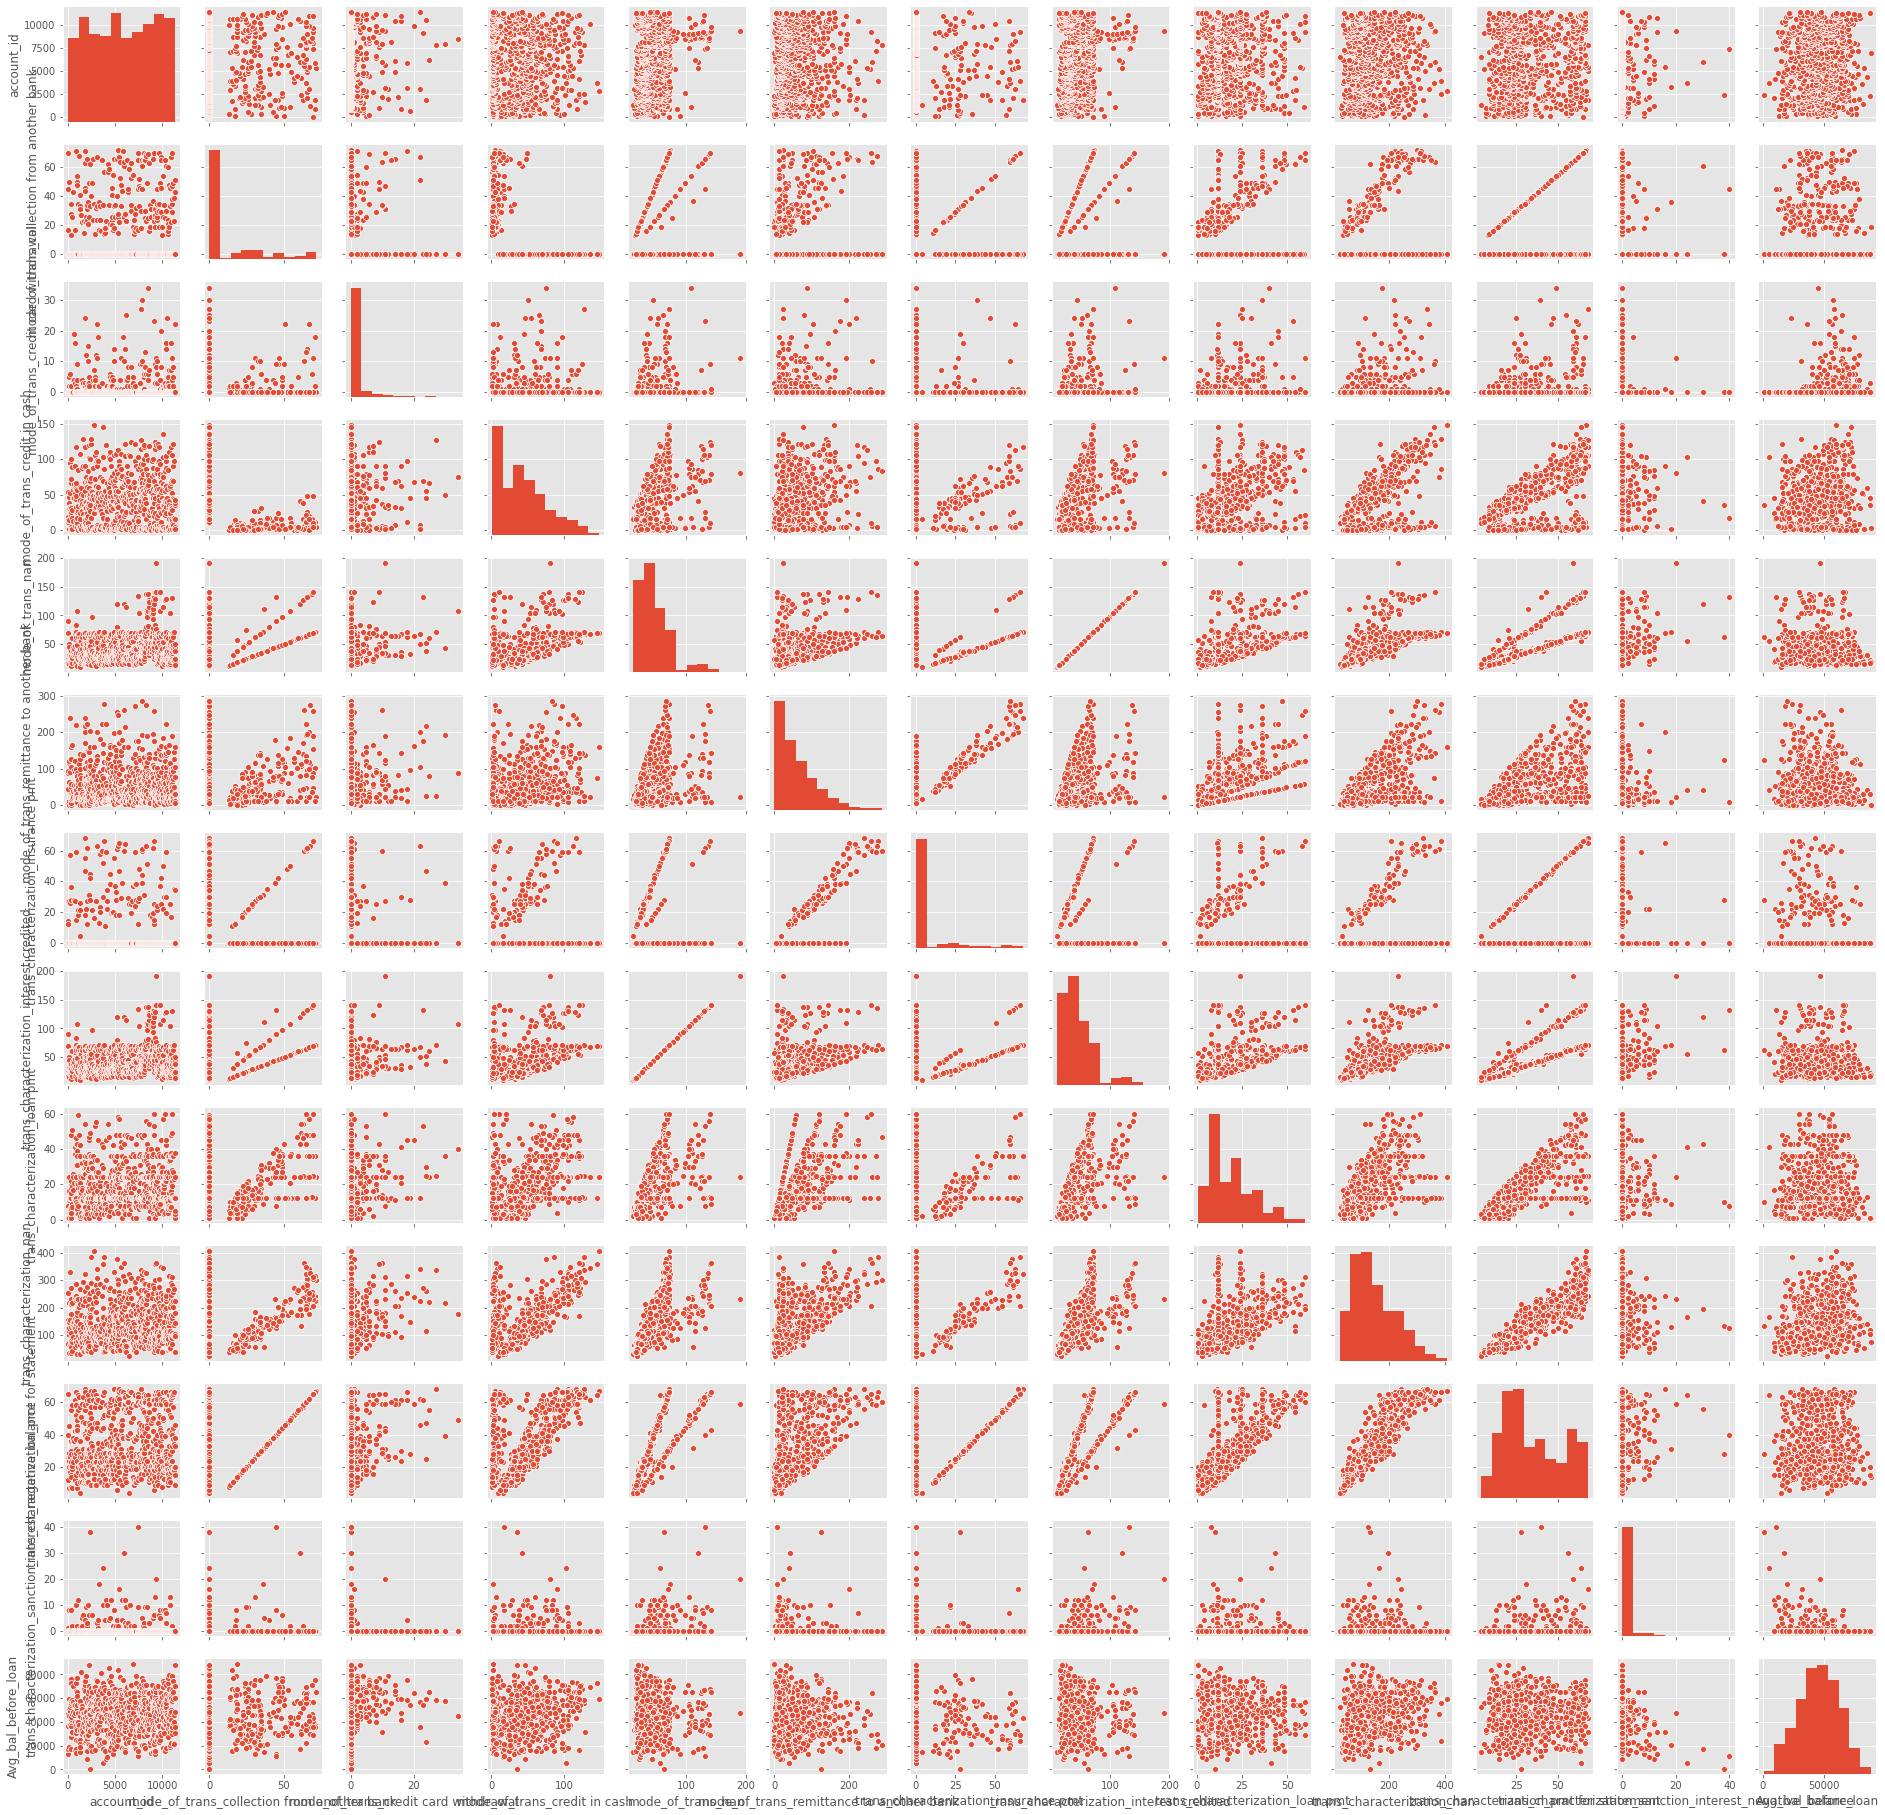

In [14]:
# Plot the correlation between features
sns.pairplot(loan_trans)
plt.tight_layout()

## Prepare Order Table and Disp Table

Order table has many information based on an order id. To be able to merge it with loan table without expanding on the account id, the table is going to be aggregated to get the sum of order amounts per payment type and account id.  To use this table, the sum of all payments can be provided or the average to get the average spending per order type. The average spending is used for this model.
disp table includes client id and type of the client.  Only owners can apply for loans so from the table, we will filter out the clients who are not owners.

In [15]:
# Drop columns that will not be used to be able to aggregate values
order.drop(["bank_to", "account_to", "order_id"], axis=1, inplace=True)

# Rename values to use them as columns
order['order_paym_type'] = order['order_paym_type'].map({'SIPO':'household pmt',
                                                         'UVER': 'loan pmt','POJISTNE':'insurance pmt',
                                                         'LEASING':'LEASING'})

#fill null values
order['order_paym_type'].fillna('order pmt type NA',inplace=True)

#groupby account id and payment type using unstack which creates a multilevel index
order = order.groupby(["account_id", "order_paym_type"]).mean().unstack()

#modify the index
order.columns = order.columns.droplevel()
order.reset_index(level="account_id", col_level=1, inplace=True)
order.rename_axis("", axis="columns", inplace=True)
order.set_index('account_id',inplace=True)

# Fill average spending with 0 for null vlues
order=order.fillna(0)

order

LEASING  household pmt  insurance pmt  loan pmt  order pmt type NA
account_id                                                                    
1               0.0         2452.0            0.0       0.0                0.0
2               0.0         7266.0            0.0    3372.7                0.0
3               0.0         1135.0         3539.0       0.0              327.0
4               0.0         1681.5            0.0       0.0                0.0
5               0.0         2668.0            0.0       0.0                0.0
...             ...            ...            ...       ...                ...
11328           0.0            0.0            0.0    4674.0                0.0
11333        3286.7            0.0            0.0       0.0                0.0
11349           0.0        10886.0            0.0    6998.0                0.0
11359           0.0         4518.0            0.0    4502.3              254.0
11362           0.0         4780.0          330.0    5392.0               92.5

[3758 rows x 5 columns]

In [16]:
#filtering disp table by type of the person, as only owners can apply for loans
disp = disp[disp['type_disp'] == "OWNER"]

## 2.4. Merge Tables

All tables will be merged into one dataframe using only the records for account ids that exist in the loan table

In [17]:
# Merge tables into one dataframe

df= loan.merge(account, how='left', on= 'account_id' , suffixes=('_loan', '_account_creation'))
df= df.merge(order,how='left', on='account_id')
df= df.merge(loan_trans, how='left',on='account_id')
df= df.merge(disp,how='left', on='account_id')
df= df.merge(client ,how='left', on='client_id')
df= df.merge(card,how='left', on='disp_id')
df= df.merge(district ,how='left', on="client_district_id")

df

loan_id  account_id   loan_date  loan_amount  loan_duration  loan_payments loan_pay_status  district_id statement_frequency_days acc_creation_date  LEASING  household pmt  insurance pmt  loan pmt  order pmt type NA  mode_of_trans_collection from another bank  mode_of_trans_credit card withdrawal  mode_of_trans_credit in cash  mode_of_trans_nan  mode_of_trans_remittance to another bank  trans_characterization_insurance pmt  trans_characterization_interest credited  trans_characterization_loan pmt  trans_characterization_nan  trans_characterization_pmt for statement  trans_characterization_sanction_interest_negative_balance  Avg_bal_before_loan  disp_id  client_id type_disp gender  birth_date  client_district_id  card_id card_type card_issued_date        dist_name           region  no_inhabitants  no_municip_less499  no_municip_500to1999  no_municip_2000to9999  no_municip_10000greater  no_cities  urban_inhabitant_ratio  dist_average_salary  unemployment_rate1995  \
0       4959           2  1994-01-05        80952             24         3373.0               A            1         POPLATEK MESICNE        1993-02-26      0.0         7266.0            0.0    3372.7                0.0                                        70.0                                   0.0                          12.0               70.0                                      89.0                                   0.0                                      70.0                             24.0                       254.0                                      65.0                                                0.0                 37082.782506        2          2     OWNER      M  1945-02-04                   1      NaN       NaN              NaN      Hl.m. Praha           Prague         1204953                   0                     0                      0                        1          1                   100.0                12541                   0.29   
1       4961          19  1996-04-29        30276             12         2523.0               B           21         POPLATEK MESICNE        1995-04-07      0.0            0.0            0.0    2523.2                0.0                                        45.0                                   0.0                          17.0               90.0                                       8.0                                   0.0                                      90.0                              8.0                       125.0                                      40.0                                                8.0                 13044.434978       25         25     OWNER      F  1939-04-23                  21      NaN       NaN              NaN            Tabor    south Bohemia          103347                  87                    16                      7                        1          7                    67.0                 9104                   1.51   
2       4962          25  1997-12-08        30276             12         2523.0               A           68         POPLATEK MESICNE        1996-07-28      0.0         6817.0          164.0    2523.2             1110.0                                         0.0                                   0.0                          54.0               28.0                                      93.0                                  27.0                                      28.0                             12.0                       154.0                                      26.0                                                0.0                 46407.908257       31         31     OWNER      M  1962-02-09                  68      NaN       NaN              NaN  Frydek - Mistek    north Moravia          228848                  15                    40                     18                        2          6                    57.2                 9893                   4.09   
3       4967          37  1998-10-14       318480             60         

## 2.5. More Feature Engineering

Values are updated for the categorical columns to use their labels in analyzing the data.  Moreover, data types are set for the date types and used in calculating new features.

In [18]:
#convert type to date

# Change statement_frequency_days column values to numeric
df['statement_frequency_days'] = df['statement_frequency_days'].map(
    {"POPLATEK MESICNE": 30, "POPLATEK TYDNE": 7, "POPLATEK PO OBRATU": 1} )

# Change card_type to numeric based on estimated weight (another way to handle this column is to keep it categorical)
df['card_type'] = card['card_type'].map({"gold": 3, "classic": 2,
                    "junior": 1})

# Create card holder feature, where card holders of any type have the value 1 and non card holders have the value 0
df['card_holder'] = df['card_type'].map({1: 1, 2: 1, 3: 1,np.nan: 0})

In [19]:
#convert type to date
df['loan_date'] = pd.to_datetime(df['loan_date'])
df['acc_creation_date'] = pd.to_datetime(df['acc_creation_date'])
df['birth_date'] = pd.to_datetime(df['birth_date'])
df['card_issued_date'] = pd.to_datetime(df['card_issued_date'])

# Get days between loan date and card issuance date

# get age at taking the loan
df['Age_at_loan'] = np.floor((df['loan_date'] - df['birth_date']).dt.days/365.25)

#get age in June 1, 1999
df['Age'] = np.floor((pd.to_datetime('1999-06-01') - df['birth_date']).dt.days/365.25)

#get years since loan was granted
df["years_of_loan"] = np.floor((pd.to_datetime('1999-06-01')-df['loan_date']).dt.days/365.25)

#get years as a client
df['years_client'] = np.floor((pd.to_datetime('1999-06-01')-df['acc_creation_date']).dt.days/365.25)

## 2.6. Set y labels

In [20]:
#rename loan status values to use them in Default column

df['loan_pay_status'] = df['loan_pay_status'].map({'A': 'Contract Ended', 'B': 'Default Past Contract period', 
                                                   'C':'Running OK','D':'Default during Contract period'})


In [21]:
# Set default label to predict. 1 represents high risk for default and 0 represents low risk for default
df['Default'] = df['loan_pay_status'].map({'Contract Ended': 0,'Default Past Contract period': 1, 
                                'Running OK':0,'Default during Contract period':1})

#dropping 'loan_pay_status' to avoid data leakage
df.drop('loan_pay_status',axis=1,inplace=True)

In [22]:
# Save the Dataframe as a checkpoint

df.to_csv('Loan_Default_Clean_Data.csv',index=False)

# 3. Exploratory Data Analysis

In [23]:
 # Load the DataFrame from the checkpoint
df= pd.read_csv('Loan_Default_Clean_Data.csv')

In [24]:
# Drop the columns that will not be used in the model as they don't have importance as features such as the id
columns_X=df.copy()
columns_X.drop(['loan_date','loan_id','account_id', 'district_id', \
         'acc_creation_date','card_id', 'disp_id','card_issued_date',\
        'client_id', 'birth_date', 'client_district_id','disp_id','client_id', 'account_id',\
         'client_district_id', 'account_id','account_id', 'type_disp',
          'dist_name'     
                ], # district name is removed because it created a distortion on the results     
               axis=1,inplace=True)

In [25]:
count_pivot=pd.pivot_table(columns_X,index='Default',aggfunc=pd.Series.nunique).T
count_pivot.columns=['count_no_default','count_default']

mean_pivot=pd.pivot_table(columns_X,index='Default',aggfunc=pd.Series.min).T
mean_pivot.columns=['mean_no_default','mean_default']

min_pivot=pd.pivot_table(columns_X,index='Default',aggfunc=pd.Series.min).T
min_pivot.columns=['min_no_default','min_default']

max_pivot= pd.pivot_table(columns_X,index='Default',aggfunc=pd.Series.max).T
max_pivot.columns=['max_no_default','max_default']

pivot_tables =  count_pivot.join(mean_pivot)
pivot_tables =  pivot_tables.join(min_pivot)
pivot_tables =  pivot_tables.join(max_pivot)
pivot_tables

count_no_default  count_default mean_no_default mean_default min_no_default min_default max_no_default   max_default
Age                                                             47.0           38.0              18           18             18          18             64            63
Age_at_loan                                                     49.0           35.0              13           15             13          15             61            60
Avg_bal_before_loan                                            606.0           76.0         9083.73      725.377        9083.73     725.377        88554.8       66616.1
LEASING                                                          1.0            1.0               0            0              0           0              0             0
card_holder                                                      1.0            1.0               1            1              1           1              1             1
card_type                                                        3.0            3.0               1            1              1           1              3             3
dist_average_salary                                             75.0           43.0            8110         8110           8110        8110          12541         12541
gender                                                           2.0            2.0               F            F              F           F              M             M
household pmt                                                  410.0           21.0               0            0              0           0          14882         11105
insurance pmt                                                  102.0           11.0               0            0              0           0           9115          7396
loan pmt                                                       545.0           72.0             304         1671            304        1671           9910          9698
loan_amount                                                    581.0           74.0            4980        29448           4980       29448         590820        541200
loan_duration                                                    5.0            5.0              12           12             12          12             60            60
loan_payments                                                  535.0           71.0             304         1671            304        1671           9910          9698
mode_of_trans_collection from another bank                      57.0           12.0               0            0              0           0             72            63
mode_of_trans_credit card withdrawal                            27.0            5.0               0            0              0           0             34            18
mode_of_trans_credit in cash                                   120.0           54.0               1            1              1           1            148           121
mode_of_trans_nan                                               87.0           49.0              10           16             10          16            191           132
mode_of_trans_remittance to another bank                       173.0           48.0               1            3              1           3            287           223
no_cities                                                       11.0           10.0               1            1              1           1             11            10
no_crimes1995                                                   75.0           43.0               0            0              0           0          85677         85677
no_crimes1996                                                   75.0           43.0             888          888            888         888          99107         99107
no_entrepreneurs_in1000                                         44.0           31.0              81           81             81          81            167           

In [26]:
pd.crosstab(columns_X['Default'],
            columns_X['gender'])
# imbalanced data but the gender is relatively balanced

gender     F    M
Default          
0        307  299
1         41   35

''

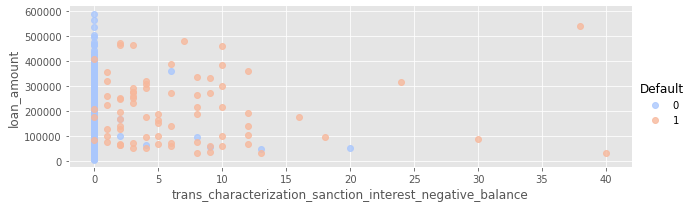

In [27]:
# Analyze the count of times the client was charged for having a negative balance, for each loan amount and the default status
sns.lmplot('trans_characterization_sanction_interest_negative_balance','loan_amount',data=columns_X, hue='Default',
           palette='coolwarm',height=3,aspect=3,fit_reg=False)
;

''

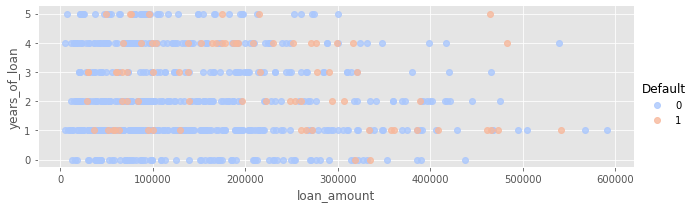

In [28]:
# Analyzing the years after taking the loan and loan amount to see how related it is to defaulting
sns.lmplot('loan_amount','years_of_loan',data=columns_X, hue='Default',
           palette='coolwarm',height=3,aspect=3,fit_reg=False)
;

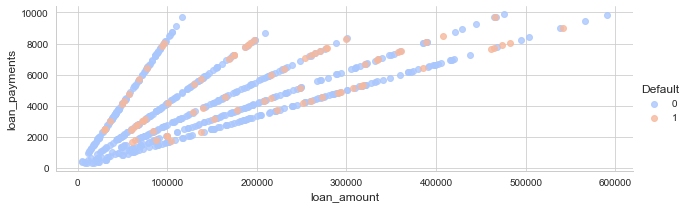

In [29]:
# Analyzing the loan payments and loan amount to see how related it is to defaulting
# We infer that the higher the amount is,the more chances clients will default
sns.set_style('whitegrid')
sns.lmplot('loan_amount','loan_payments',data=columns_X, hue='Default',
           palette='coolwarm',height=3,aspect=3,fit_reg=False);

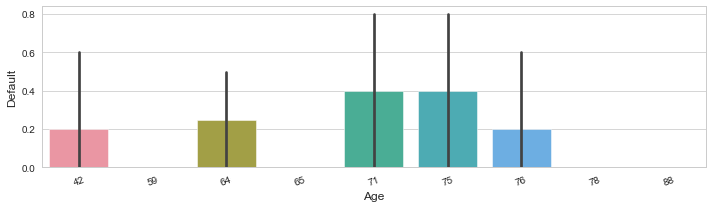

In [30]:
plt.figure(figsize=(10,3))
sns.barplot(x=columns_X['Age'].value_counts(bins=10),y=df['Default']);

plt.xticks(rotation=20)
plt.tight_layout()

Index(['loan_amount', 'loan_duration', 'loan_payments', 'statement_frequency_days', 'LEASING', 'household pmt', 'insurance pmt', 'loan pmt', 'order pmt type NA', 'mode_of_trans_collection from another bank', 'mode_of_trans_credit card withdrawal', 'mode_of_trans_credit in cash', 'mode_of_trans_nan', 'mode_of_trans_remittance to another bank', 'trans_characterization_insurance pmt', 'trans_characterization_interest credited', 'trans_characterization_loan pmt', 'trans_characterization_nan', 'trans_characterization_pmt for statement', 'trans_characterization_sanction_interest_negative_balance', 'Avg_bal_before_loan', 'card_type', 'no_inhabitants', 'no_municip_less499', 'no_municip_500to1999', 'no_municip_2000to9999', 'no_municip_10000greater', 'no_cities', 'urban_inhabitant_ratio', 'dist_average_salary', 'unemployment_rate1995', 'unemployment_rate1996', 'no_entrepreneurs_in1000', 'no_crimes1995', 'no_crimes1996', 'card_holder', 'Age_at_loan', 'Age', 'years_of_loan', 'years_client',
      

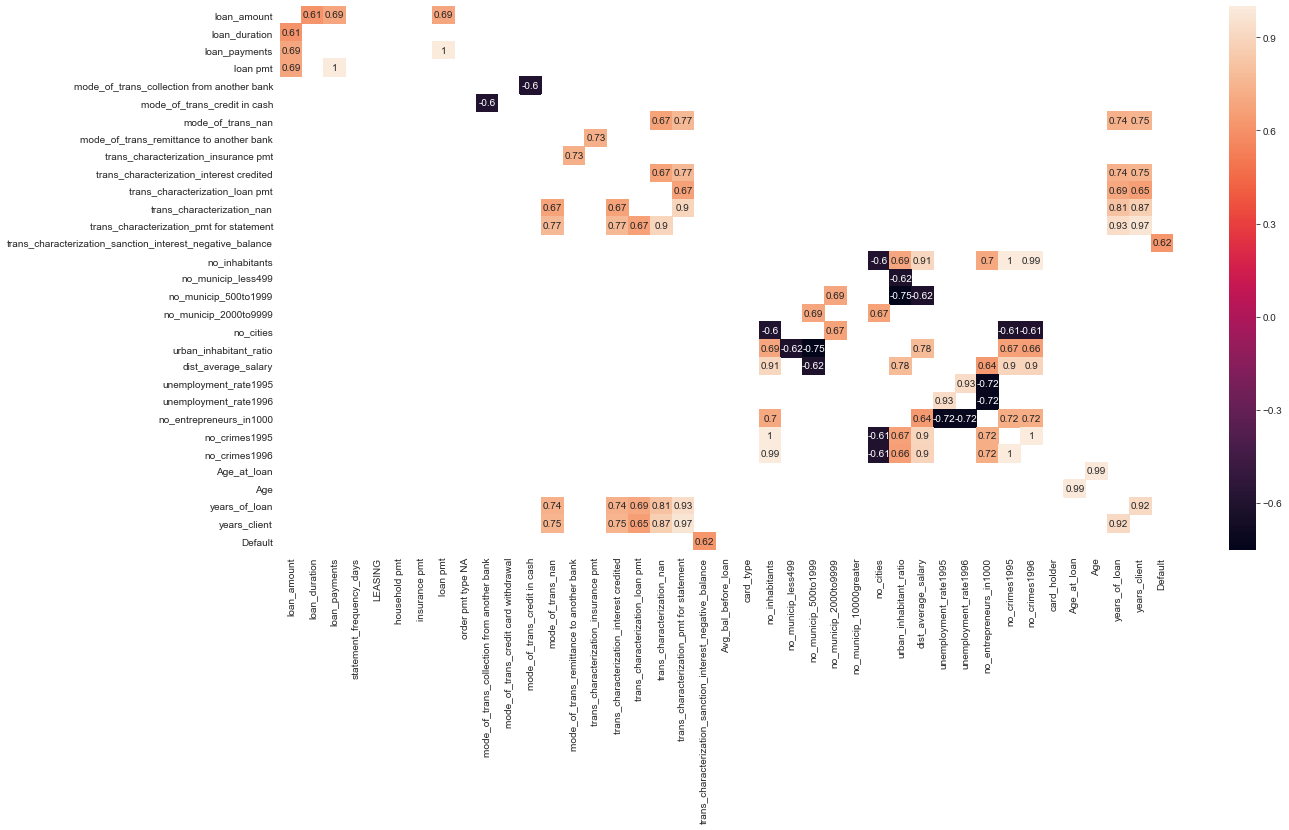

In [31]:
# show the highly correlated features, in this case we chose 60% positive or negative to be highly correlated.
plt.figure(figsize=(20,10))
print(columns_X.corr()[(columns_X.corr() >0.6) & (columns_X.corr() !=1) | (columns_X.corr() <-0.6) & (columns_X.corr() !=1)].columns)
sns.heatmap(columns_X.corr()[(columns_X.corr() >0.6) & (columns_X.corr() !=1) | (columns_X.corr() <-0.6) & (columns_X.corr() !=1)].dropna(thresh=1),annot=True);

## Investigate the relationship between the labels and trans_characterization_sanction_interest_negative_balance feature

In [32]:
print('after loan',trans_after_loan['trans_characterization'].value_counts().loc['sanction_interest_negative_balance'])
print('before loan',trans_before_loan['trans_characterization'].value_counts().loc['sanction_interest_negative_balance'])
columns_X[['trans_characterization_sanction_interest_negative_balance','Default']].head(100)

after loan 82
before loan 507


trans_characterization_sanction_interest_negative_balance  Default
0                                                 0.0                0
1                                                 8.0                1
2                                                 0.0                0
3                                                 1.0                1
4                                                 0.0                0
5                                                 0.0                0
6                                                 0.0                0
7                                                 8.0                1
8                                                 0.0                0
9                                                 0.0                0
10                                                0.0                0
11                                                0.0                0
12                                                0.0                0
13                                                0.0                0
14                                                0.0                0
15                                                0.0                0
16                                                0.0                0
17                                                0.0                0
18                                                0.0                0
19                                                0.0                0
20                                                0.0                0
21                                                0.0                0
22                                                0.0                0
23                                                8.0                1
24                                                0.0                0
25                                                0.0                0
26                                                2.0                1
27                                                0.0                0
28                                                1.0                1
29                                                2.0                1
30                                                0.0                0
31                                                0.0                0
32                                                0.0                0
33                                                0.0                0
34                                                0.0                0
35                                                0.0                0
36                                                0.0                0
37                                                0.0                0
38                                                0.0                1
39                                               10.0                1
40                                                0.0                0
41                                                0.0                0
42                                                0.0                0
43                                                0.0                0
44                                                0.0                0
45                                                0.0                0
46                                                0.0                0
47                                                0.0                0
48                                                0.0                0
49                                                0.0                0
50                                                0.0                0
51                                                0.0                0
52                                                0.0                0
53                                                0.0                0
54                                                2.0                0
55                          

## Checking for missing values

In [33]:
# Check for null values per column. True is null
for item in columns_X:
    if True in columns_X[item].isnull().value_counts():
        print(columns_X[item].isnull().value_counts())

# drop column with missing values as the missing values are only in 'statement_frequency_days' column.

# Splitting, Scaling, & Normalizing the Data

Due to the small number of default cases in the dataset, the data will be split into two sets (train and test sets) instead of three sets. This decision was made after trying to run the model with three sets and found out that data imbalance does not allow for proper splitting between three sets. To normalize the data, firstly, the dataset is scaled using Standard Scaler, then the data imbalance is treated using SMOTE oversampler

In [34]:
#getting numeric values for all columns to fit them in the model
X=pd.get_dummies(columns_X,dummy_na=False, drop_first=True)
X.drop(['Default'],axis=1,inplace=True)

y = df['Default'].values

# After running the model and interpretation, features  that don't provide useful insight are removed.
X.drop(['statement_frequency_days','unemployment_rate1995','no_inhabitants',
        'no_cities','no_municip_2000to9999',
        'unemployment_rate1995','card_holder',
        'no_crimes1995', 'no_municip_less499',
        'no_municip_500to1999','no_municip_2000to9999','no_municip_10000greater']
       ,inplace=True
       ,axis=1)

*Re-selecting Features*

In [35]:
# Use train_test_split from SKlearn to split the data (80% training set, 20% testing set)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Normalize/Scale the Data using MinMaxScaler and keep them as a dataframe format to easily read them

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns, index=X_train.index)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Handle data imbalance by oversampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train.shape , X_test.shape , y_train.shape , y_test.shape

C:\Users\samad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\samad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\samad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

((974, 38), (137, 38), (974,), (137,))

# Machine Learning Model

To select the best machine learning algorithm, a set of models will be tested for baseline score then the model with the best score will be selected and optimized by tuning its parameters.

In [36]:
# Select models that are used for classification
models = {"SVC": SVC(),
          'Decision Tree' : DecisionTreeClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

# Create function to fit and return model score
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

''

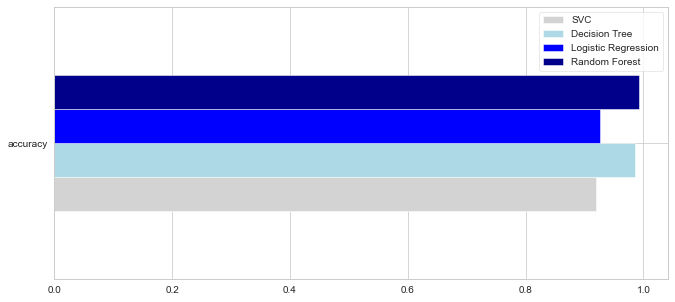

In [37]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

#comparing the scores of each model (Random Forest yields the best score)
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.plot(kind='barh',color=['lightgrey','lightblue','blue','darkblue'],figsize=(11,5))
;

# Optimizing the Model

Random Forest Classifier gave the best prediction score.  Model's parameter will be explored and tested with different values in order to get the best parameters to increase model's prediction.

In [38]:
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier()

# scoring=accuracy means accuracy metric is used
print(cross_val_score(estimator=rfc, 
                      X=X_train, 
                      y=y_train, 
                      cv=5, # use 5-fold cross-validation
                      scoring='accuracy')) 

# Evaluate a model with a different scoring method
print(cross_val_score(estimator=rfc, 
                      X=X_train, 
                      y=y_train,
                      cv=5, # use 5-fold cross-validation
                      scoring="precision"))

# Evaluate a model with a different scoring method
print(cross_val_score(estimator=rfc, 
                      X=X_train, 
                      y=y_train,
                      cv=5, # use 5-fold cross-validation
                      scoring="recall"))

[0.97435897 0.99487179 0.98974359 1.         0.98453608]
[0.9893617  0.98979592 0.97979798 1.         0.97      ]
[0.95876289 1.         0.98979592 1.         1.        ]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       119
           1       1.00      0.89      0.94        18

    accuracy                           0.99       137
   macro avg       0.99      0.94      0.97       137
weighted avg       0.99      0.99      0.99       137



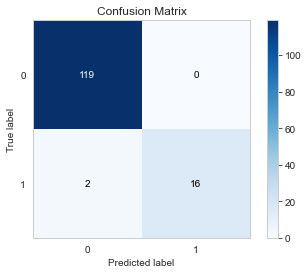

In [39]:
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test,y_pred))

# Improve model

The performance of the model is highly accurate as there is a high correlation between the engineered feature ('trans_characterization_sanction_interest_negative_balance') and the labels('Default').  The column can be seen to have a data leakage effect but, since this feature is important. The relationship was investigated and it was found that majority of the cases were before the loan was taken. It was decided to keep this feature on the assumption that clients who incurred this transaction before taking the loan are most likely to default.
The optimization will be focusing on higher accuracy in predicting all default cases in the test set.

In [40]:
## Gridsearch Practice
import random
from sklearn.model_selection import GridSearchCV
rfc_param_grid = {"n_estimators": np.arange(100,1200,100),
           "max_depth": [None, 5, 10,13, 20],
           "min_samples_split": np.arange(2, 12, 3),
           "min_samples_leaf": np.arange(1, 15, 3)}

In [41]:
# Setup random hyperparameter search for RandomForestClassifier to get the best parameters
rfc_grid = GridSearchCV(RandomForestClassifier(),
                           rfc_param_grid,
                           cv=5,
                           verbose=True,
                           n_jobs= -1)

# Fit random hyperparameter search model
rfc_grid.fit(X_train, y_train);

# Print the best parameters
rfc_grid.best_params_

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 5500 out of 5500 | elapsed: 19.7min finished


{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

# Re-Test & Evaluate The Model

In [44]:
# Use best parameters in rfc model
rfc_= RandomForestClassifier(max_depth= 20,
                            min_samples_leaf= 1,
                            min_samples_split= 2,
                            n_estimators= 200)

rfc_.fit(X_train, y_train)

predictions = rfc_.predict(X_test)
proba_prediction = rfc_.predict_proba(X_test)

print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[119   0]
 [  1  17]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       119
           1       1.00      0.94      0.97        18

    accuracy                           0.99       137
   macro avg       1.00      0.97      0.98       137
weighted avg       0.99      0.99      0.99       137



In [45]:
# Test the model on the Data before scaling to see the results without scaling
print(cross_val_score(estimator=rfc_, 
                      X=X, 
                      y=y, 
                      cv=5, # use 5-fold cross-validation
                      scoring='accuracy')) 

# Evaluate a model with a different scoring method
print(cross_val_score(estimator=rfc_, 
                      X=X, 
                      y=y, 
                      cv=5, # use 5-fold cross-validation
                      scoring="recall"))

[0.95620438 0.97810219 0.99264706 0.96323529 0.98529412]
[0.73333333 0.9375     0.93333333 0.86666667 0.93333333]


In [46]:
# R^2 (pronounced r-squared) or coefficient of determination
from sklearn.metrics import r2_score
print(r2_score(y_test,predictions))

# Mean absolute error (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test,predictions))

# Mean square error (MSE)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test,predictions))

0.9360410830999066
0.0072992700729927005
0.0072992700729927005


## Interpreting the Model

Find the features that are most important in affecting the prediction output in order to select the features that could be dropped to improve the model's performance.

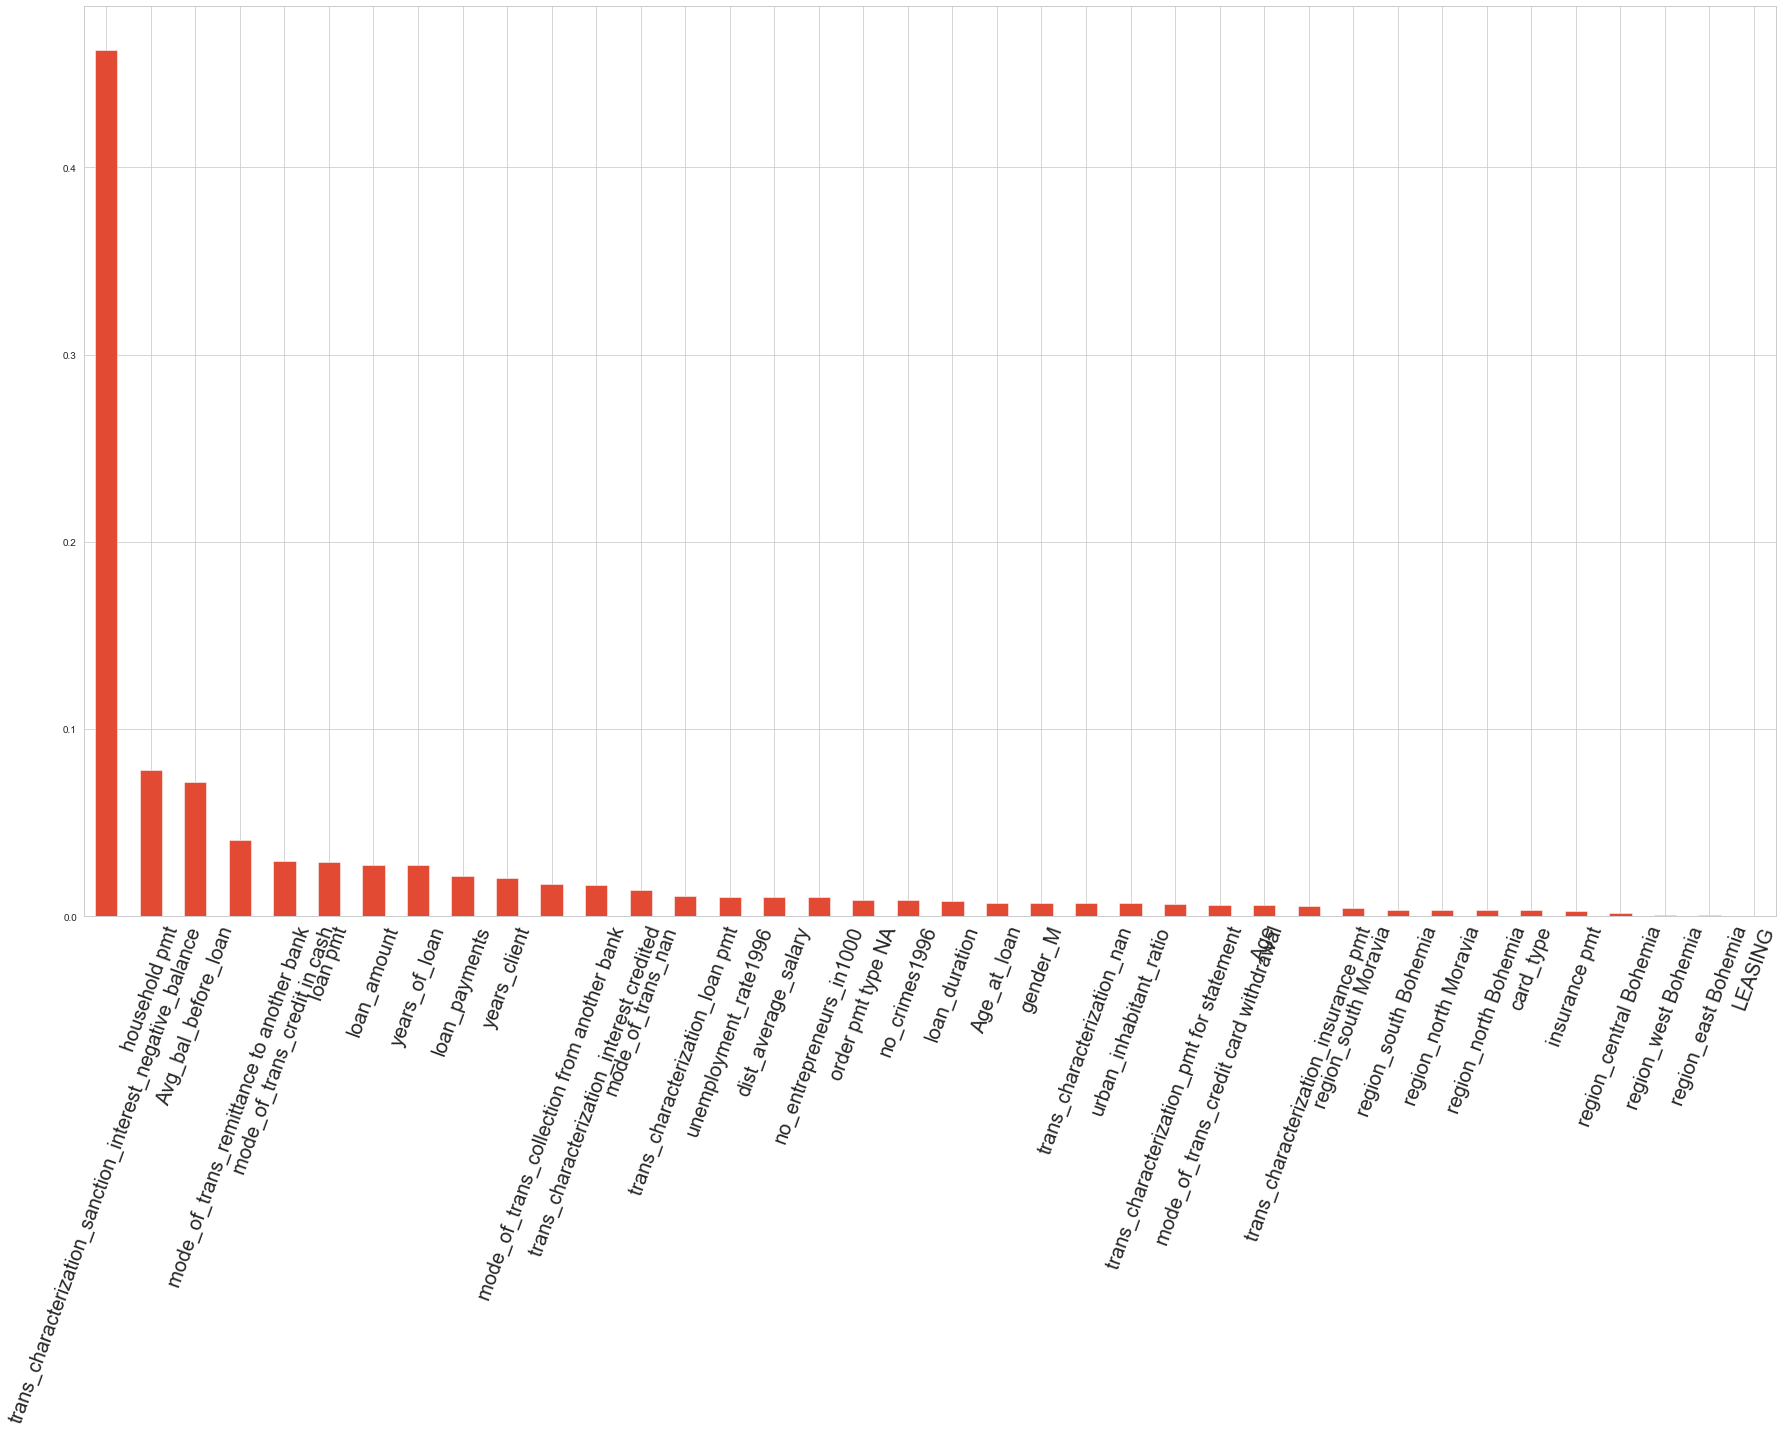

In [47]:
# Get the feature importance for Random Forest Classification model
plt.figure(figsize=(25,20))
pd.Series(rfc_.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar');

plt.xticks(rotation=70,size=20,)
plt.tight_layout()

In [48]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_, random_state=42)

perm.fit(X_train, y_train)

eli5.show_weights(perm, feature_names=X.columns.tolist(),top=200)

C:\Users\samad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\samad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [49]:
# Find the incorrect predictions to findout why it was incorrect and make adjustments to the model as needed using lime
i=-1
for item in list(zip(y_test,predictions)): # show prediction and the actual value next to each other
    i+=1 # create an index number
    if item[0] != item[1]:
        print(item, i)
    else:
        pass

(1, 0) 109


Intercept 0.6269929171445399
Prediction_local [0.61114968]
Right: 0.405


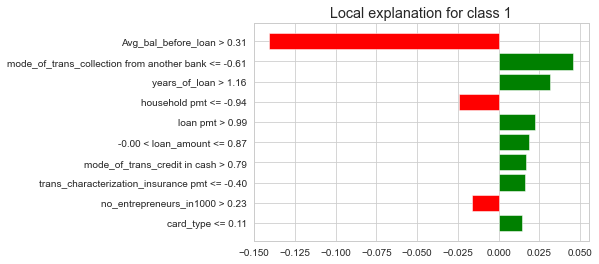

In [50]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                    feature_names=X.columns,                             
                    verbose=True, 
                    mode='classification')

# Visualize the interpretation
exp = explainer.explain_instance(X_test.iloc[109], rfc_.predict_proba)
exp.as_pyplot_figure()
exp.show_in_notebook(show_table=True, show_all=False)